# Génération de gaussienne par modèle de diffusion

<h2>Importation</h2>

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import normal
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

<h2>Affichage des points</h2>

<p>Fonction qui prend en argument des points sous forme de tableau numpy ou bien de tensor et qui les affiche</p>

In [3]:
def show_points(X):
    nb_points, dim = X.shape
    plt.figure(figsize=(dim*(dim-1) * 10,5))
    nb_plot = 0
    for d1 in range(dim):
        for d2 in range(d1 + 1, dim):
            xs, ys = [], []
            nb_plot += 1
            for i in range(nb_points):
                xs.append(X[i][d1])
                ys.append(X[i][d2])
            plt.subplot(1, dim**2, nb_plot)
            plt.title(f"({d1},{d2})")
            plt.scatter(xs, ys, marker='+')
    plt.show()
    return

<h2>Modèles</h2>

<p>On utilise différent modèles : 
    <ul>
        <li>Le modèle Net. C'était notre modèle initiale qui contient seulement quelques couches linéaires</li>
        <li>DiffusionBlock : Contient le block du milieu pour le modèle DiffusionModel</li>
        <li>DiffusionModel : Contient un modèle assez similaire à celui utilisé dans le notebook</li>
        <li>Diff : Modèle qui va gérer toute la diffusion</li>
</p>

In [4]:
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        t = t.reshape(-1, 1)
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

class Diff(nn.Module):
    def __init__(self,network, num_timesteps,beta_start = 1e-4, beta_end = 0.1, device = "cpu"):
        super(Diff,self).__init__()
        self.num_timesteps = num_timesteps
        self.network = network
        self.device = device
        
        s = 0.008
        timesteps = torch.tensor(range(0, num_timesteps), dtype=torch.float32)
        schedule = torch.cos((timesteps / num_timesteps + s) / (1 + s) * torch.pi / 2)**2
        self.alphas_cumprod = schedule / schedule[0]
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod)**0.5
        self.betas = 1 - self.alphas_cumprod / torch.concatenate([self.alphas_cumprod[0:1], self.alphas_cumprod[0:-1]])
        self.alphas = 1 - self.betas

    def plot_alphacumprods(self):
        #Fonction qui permet d'afficher les beta et de vérifier que la courbe a à peu près la forme voulue
        plt.plot(torch.arange(1, num_timesteps + 1), self.alphas_cumprod)
        plt.show()
        
    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps].reshape(-1, 1).to(device) # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1, 1).to(device) # bs
        return s1 * x_start + s2 * x_noise
        
    def reverse(self,x,t):
        return self.network(x,t)
        
    def step(self, model_output, timestep, sample):
        # model_output = epsilon_theta, timestep = t, sample = x_t
        # but: avoir x_{t-1}
        t = timestep
        coef_eps_t = ((1 - self.alphas[t]) / self.sqrt_one_minus_alphas_cumprod[t]).reshape(-1,1).to(device)
        coef_first_t = (1 / self.alphas[t] ** 0.5).reshape(-1,1).to(device)
        pred_prev_sample = (coef_first_t * (sample - coef_eps_t * model_output)).to(device)
        variance = 0
        if t > 1:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise).to(device)

        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample.to(device)

<h2>Training loop</h2>
<p>La training loop est simple, on optimise pour apprendre le bruit aouté à chaque étape</p>

In [5]:
def training_loop(model,dataloader,optim,num_ep,num_timesteps,device=device):
    global_step = 0
    losses = []
    
    for epoch in range(num_ep):
        if epoch != 0 and epoch % 10 == 0:
            print(f"New epoch ({epoch}) last losses: {losses[-1]}, average lost on the last ten epoch : {sum(losses[-10:]) / 10}")
        model.train()
        l = 0
        
        for step, batch in enumerate(dataloader):
            batch = batch.to(device) # les x0 avec lesquels je vais me train.
            eps = torch.randn(batch.shape).to(device) # un epsilon par x0 pour les flouter
            timesteps = torch.randint(model.num_timesteps,(batch.shape[0],)).long().to(device)
            noisy = model.add_noise(batch, eps, timesteps) # xt
            noise_pred = model.reverse(noisy, timesteps) # on essaye de prédire le epsilon à partir des images floutées.
            loss = F.mse_loss(noise_pred, eps)
            optim.zero_grad()
            loss.backward()
            optim.step()
            l += loss.detach().item()
            global_step += 1
        losses.append(l / len(dataloader))
        
    plt.plot(torch.arange(num_ep), losses)
    plt.show()

<h2>Dataset</h2>
<p>On créer une classe MultivariateNormalDataset qui permet de générer des points selon différentes distributions gaussiennes. A terme, le but serait d'avoir différentes classe permettant d'avoir différents types de distributions afin de vérifier que ça apprend bien à chaque fois</p>

In [6]:
class MultivariateNormalDataset(Dataset):
    def __init__(self, mean, std, num_samples):
        mean = mean.expand(num_samples, -1)
        std = std.expand(num_samples, -1)
        self.data = torch.normal(mean=mean, std=std)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

<h2>Génération de points</h2>

In [7]:
def genere_un_point(model):
    sample = torch.randn(dim).unsqueeze(0).to(device)
    evolution = sample.clone().detach()
    model.eval()
    with torch.no_grad():
        timesteps = list(range(1, model.num_timesteps))[::-1]
        for t in timesteps:
            time_tensor = (torch.ones(1,) * t).long().to(device)
            residual = model.reverse(sample,time_tensor)
            sample = model.step(residual,time_tensor,sample)
            evolution = torch.concatenate((evolution, sample))
            # p(xt-1 | xt), prend en entrée le epislon_theta, et le temps où on est, et la version floutée.
    return sample, evolution

def genere_points(nb_points, model):
    X = torch.tensor([])
    X = X.to('cpu')
    evolution_X = torch.tensor([])
    evolution_X = evolution_X.to('cpu')
    
    for i in range(nb_points):
        if i % 100 ==0 and i != 0: 
            print(f"generated {i} points.")
        x, evolution_x = genere_un_point(model)
        x = x.to('cpu')
        evolution_x = evolution_x.to('cpu')
        X = torch.concatenate((X, x))
        evolution_X = torch.concatenate((evolution_X, evolution_x.reshape(1, -1, 2)), axis=0)

    return X, evolution_X

<h2>Routine d'entraînement</h2>
<p>C'est ici qu'on définit notre routine d'entraîenement et d'affichage des résultats qui est globalement la même. Elle est composée de
<ul>
    <li>Entraînement du modèle</li>
    <li>Affichage des résultats sous la forme de plusieurs étapes qui montre comment les points vont se déplacer petit à petit vers la distribution voulue</li>
</ul>
</p>

In [8]:
def routine(network, model, dataset, dataloader, num_epochs, num_timesteps, num_points_genere, nb_etape_affiche, label = "", figsize=(16,4), lr=1e-3):
    
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    training_loop(model, dataloader, optimizer, num_epochs, num_timesteps)

    X, evolution_X = genere_points(num_points_genere, model)
    print(len(evolution_X[0]))
    #show_points(X)

     # Création de la figure avec des sous-plots
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    positions = [0, num_timesteps // 2, num_timesteps - 1]  # Affiche les 3 étapes (début, milieu, fin)

    handles, labels = None, None
    
    for (i, pos) in enumerate(positions):
        # Sous-plot actuel
        ax = axes[i]

        # Ajout des points bruités et des points générés
        ax.scatter(
            dataset.data[:, 0],
            dataset.data[:, 1],
            color='darkviolet',
            alpha=0.7,
            marker='+',
            #label='Original data'
        )
        ax.scatter(
            evolution_X[:, pos, 0],
            evolution_X[:, pos, 1],
            color='darkblue',
            alpha=0.7,
            marker='+',
            #label='Evolved data'
        )

        # Paramètres esthétiques
        ax.set_title(f"Step {pos}", fontsize=16)
        #ax.set_xlabel('Feature 1', fontsize=14)
        #ax.set_ylabel('Feature 2', fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        ax.tick_params(axis='both', labelsize=12)

        if handles is None and labels is None:
            handles, labels = ax.get_legend_handles_labels()

    # Légende générale
    """fig.legend(
    handles, labels,
    loc='upper center',
    ncol=2,
    fontsize=12,
    frameon=False  # Pas de cadre autour de la légende
)"""

    fig.legend(
    ['Original Data', 'Evolved Data'],  # Noms des catégories
    loc='upper center',                 # Position au centre haut
    ncol=2,                             # Nombre de colonnes dans la légende
    bbox_to_anchor=(0.5, 1.1)           # Déplacement au-dessus des graphiques
)

    #fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))

    # Optimisation de l'espacement
    plt.subplots_adjust(left=0.1, wspace=0.1)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustement pour ne pas couper le titre
    plt.show()

    return X

<h2>Mise en pratique</h2>
<p>On va entraîner notre modèle sur des distributions de difficultés variables. A noter qu'il semble qu'à chaque fois il est nécéssaire de redéfinir toutes les constantes beta_start, beta_end, nombre de sample et nombre d'étapes de bruitage parce que c'est directement lié au dataset qu'on essaie de générer. En effet, il faut faire d'avoir le bon nombre de num_steps de sorte que ça suffise pour transformer notre distribution initiale en quelques chose de gaussien centré en 0 et de variance 1, mais pas plus car autrement ça fausse les résultats à la fin. Pour cela, on commence par créer une fonction plot_full_noise qui permet d'appliquer tout le bruit sur notre dataset de départ et de voir si la pahse de bruitage est suffisament longue</p>

In [9]:
def get_full_noise(dataset, model):
    noise = torch.randn(dataset.data.shape).to(device) # un epsilon par x0 pour les flouter
    timesteps = torch.full((dataset.data.shape[0],), model.num_timesteps - 1).long().to(device)
    noisy = model.add_noise(dataset.data, noise, timesteps)
    return noisy 

<h3>Gaussiennes</h3>

In [10]:
num_samples = 10000  # Number of samples
batch_size = 2048   # Batch size

#On commence avec une gaussienne centrée en (6, 6) et avec une variance de (2, 2)
dim=2
mean = 4*torch.ones((dim,))
std = 2*torch.ones((dim,))

dataset = MultivariateNormalDataset(mean,std, num_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
num_epochs = 200
num_timesteps = 21

network = DiffusionModel(dim, nblocks=2, nunits=64).to(device)
model = Diff(network,num_timesteps,device = device)

New epoch (10) last losses: 0.7837820053100586, average lost on the last ten epoch : 0.8754172122478485
New epoch (20) last losses: 0.7520583987236023, average lost on the last ten epoch : 0.7724740016460419
New epoch (30) last losses: 0.7470663189888, average lost on the last ten epoch : 0.7448431122303009
New epoch (40) last losses: 0.7227748036384583, average lost on the last ten epoch : 0.7302830219268799
New epoch (50) last losses: 0.7200791835784912, average lost on the last ten epoch : 0.7150365936756133
New epoch (60) last losses: 0.7051489591598511, average lost on the last ten epoch : 0.7091329061985017
New epoch (70) last losses: 0.6991936922073364, average lost on the last ten epoch : 0.7029927885532379
New epoch (80) last losses: 0.7086668133735656, average lost on the last ten epoch : 0.6999350512027741
New epoch (90) last losses: 0.6923818588256836, average lost on the last ten epoch : 0.6967914974689484
New epoch (100) last losses: 0.705699336528778, average lost on the

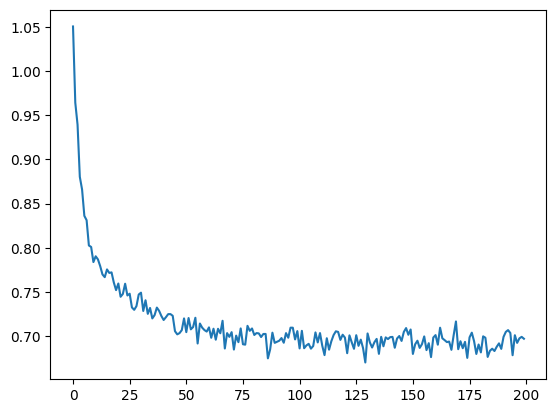

generated 100 points.
generated 200 points.
generated 300 points.
generated 400 points.
generated 500 points.
generated 600 points.
generated 700 points.
generated 800 points.
generated 900 points.
21


/tmp/ipykernel_10388/3825861622.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=12)


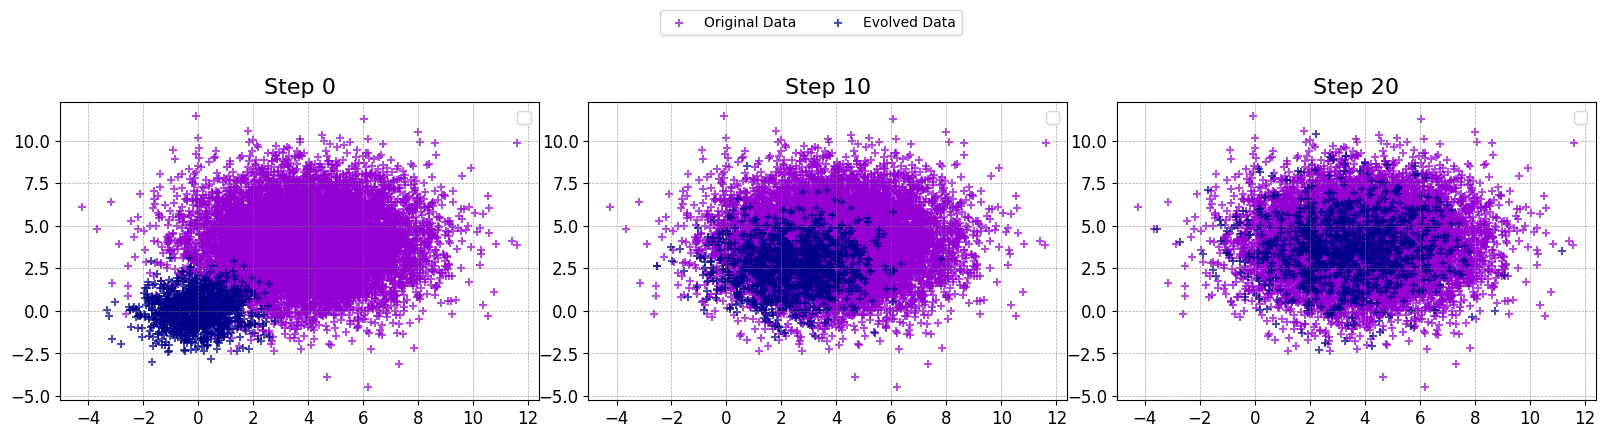

In [12]:
X = routine(network, model, dataset, dataloader, num_epochs, num_timesteps, 1000, 4, label = 'Gaussienne')

<h2>Gaussiennes plus compliquée</h2>

In [13]:
class NormalDatasetDifficile(Dataset):
    def __init__(self, mean1, std1, mean2, std2, num_samples):
        mean1 = mean1.expand(num_samples, -1)
        std1 = std1.expand(num_samples, -1)
        mean2 = mean2.expand(num_samples, -1)
        std2 = std2.expand(num_samples, -1)
        self.data = torch.concatenate((torch.normal(mean=mean1, std=std1), torch.normal(mean=mean2, std=std2)))
        self.num_samples = num_samples * 2

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

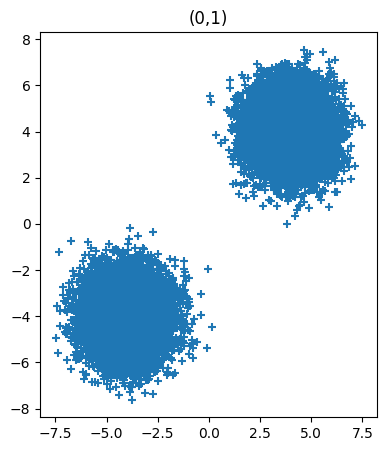

In [14]:
num_samples = 10000  # Number of samples
batch_size = 2048   # Batch size
dim = 2

mean1 = 4*torch.ones((dim,))
std1 = 1*torch.ones((dim,))
mean2 = (-4)*torch.ones((dim,))
std2 = 1*torch.ones((dim,))

dataset_diff = NormalDatasetDifficile(mean1, std1, mean2, std2, num_samples)
show_points(dataset_diff.data)
dataloader_diff = DataLoader(dataset_diff, batch_size=batch_size, shuffle=True)

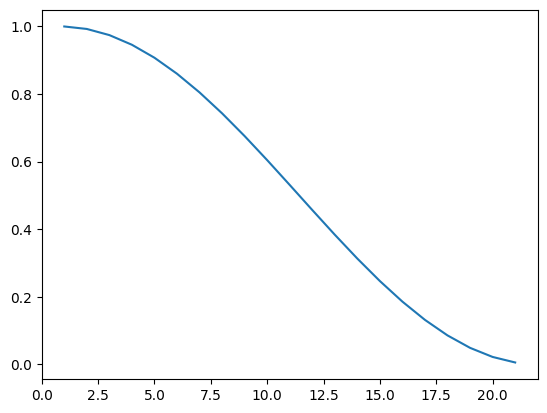

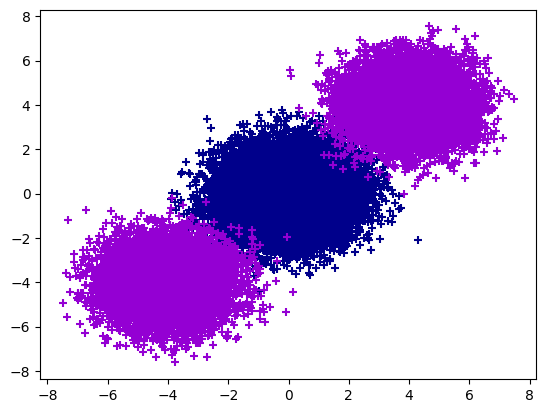

In [17]:
num_epochs = 200
num_timesteps = 21

network_diff = DiffusionModel(dim, nblocks=4, nunits=64).to(device)
model_diff = Diff(network_diff, num_timesteps, device = device)
model_diff.plot_alphacumprods()

noisy = get_full_noise(dataset_diff, model_diff)
plt.scatter(noisy[:, 0], noisy[:, 1], color='darkblue', marker='+')
plt.scatter(dataset_diff.data[:, 0], dataset_diff.data[:, 1], color='darkviolet', marker='+')
plt.show()

#print(f"Moyenne de la distribution bruitée : {torch.mean(noisy, axis=0)}")
#print(f"Variance de la distribution bruitée : {torch.std(noisy, axis=0)}")

In [ ]:
X = routine(network_diff, model_diff, dataset_diff, dataloader_diff, num_epochs, num_timesteps, 1000, 2)

<h2>Distribution en spirale</h2>
<p>Distribution en forme de spirale qui normalement devrait être un peu plus dure à apprendre. Petite remarque : jusqu'à maintenant on ne faisait pas le classique centralisation + normalisation avant d'apprendre parce que ça aurait un peu faussé tout l'intérêt de nos distributions précédentes, mais à partir de maintenant il faut le faire</p>

In [ ]:
class SpiraleDataset(Dataset):
    def __init__(self, theta_max, a, b, num_samples):
        theta = torch.rand(num_samples) * theta_max
        radius = a + b * theta
        
        self.data = torch.stack((radius * torch.cos(theta), radius * torch.sin(theta)), dim=1)
        self.data -= torch.mean(self.data, axis=0)
        self.data /= torch.std(self.data, axis=0)
        
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
num_samples = 10000  # Number of samples
batch_size = 2048   # Batch size

dataset_spirale = SpiraleDataset(5 * torch.pi, 0, 5, num_samples)
show_points(dataset_spirale.data)
dataloader_spirale = DataLoader(dataset_spirale, batch_size=batch_size, shuffle=True)

In [ ]:
num_epochs = 1000
num_timesteps = 41

network_spirale = DiffusionModel(dim, nblocks=4, nunits=64).to(device)
model_spirale = Diff(network_spirale, num_timesteps, device = device)
model_spirale.plot_alphacumprods()

noisy = get_full_noise(dataset_spirale, model_spirale)
plt.scatter(noisy[:, 0], noisy[:, 1], color='blue')
plt.scatter(dataset_spirale.data[:, 0], dataset_spirale.data[:, 1], color='red')
plt.show()

#print(f"Moyenne de la distribution bruitée : {torch.mean(noisy, axis=0)}")
#print(f"Variance de la distribution bruitée : {torch.std(noisy, axis=0)}")

In [ ]:
X = routine(network_spirale, model_spirale, dataset_spirale, dataloader_spirale, num_epochs, num_timesteps, 1000, 2)

<h2>MNIST</h2>
<p>Maintenant on va commencer à générer des vraies images en commençant par MNIST. On commence à utiliser des U-NET pour pouvoir traiter les images correctement</p>

In [ ]:
import torch
import torch.nn as nn
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the 
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2, 
            stride=2)
        # Below, in_channels again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2, 
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2, 
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2, 
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => out_channels as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes, 
            kernel_size=1
        ) 
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)        
        
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out

In [ ]:
class MNISTDataset(Dataset):

    def __init__(self, num_samples=1000, val_chiffre=range(0, 10)): #Par défaut on prend tous les types de chiffre
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
        train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

        train_images = train_dataset.data.unsqueeze(1).float() / 255
        train_images = (train_images - 0.5) / 0.5
        position = torch.randperm(train_images.shape[0])[:num_samples]
        train_images = train_images[position]

        self.data = train_images
        self.num_samples = num_samples
        self.dim = train_images.shape

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

<p>On change aussi la routine qui n'est plus la même vu qu'on a des images et plus des simples points à plot</p>

In [ ]:
def routine(network, model, dataset, dataloader, num_epochs, num_timesteps, num_points_genere, figsize=(16,4), lr=1e-3):
    
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    training_loop(model, dataloader, optimizer, num_epochs, num_timesteps)

    X, evolution_X = genere_points(num_points_genere, model)
    #show_points(X)

    fig, axes = plt.subplots(1, num_point_genere, figsize=figsize)

    inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.5 / 0.5], std=[1 / 0.5]),  # Dénormalisation
    transforms.ToPILImage()  # Convertir le tenseur en image PIL
    ])
    
    for i in range(num_point_genere):
        img = inverse_tranform(X[i])
        axes[i].imshow(img)

    plt.tight_layout()
    plt.show()

    return X

In [ ]:
num_samples = 1000
batch_size = 256

dataset_mnist = MNISTDataset(num_samples=num_samples)
#show_points(dataset_mnist.data)
dataloader_mnist = DataLoader(dataset_mnist, batch_size=batch_size, shuffle=True)

In [ ]:
num_epochs = 10
num_timesteps = 50

network_mnist = UNet(10)
model_mnist = Diff(network_mnist,num_timesteps,device = device)

In [ ]:
X = routine(network_mnist, model_mnist, dataset_mnist, dataloader_mnist, 10, num_timesteps, 3, figsize=(40, 4))

In [ ]:
t1 = torch.tensor([1, 2, 3])
t2 = torch.tensor([[1, 2, 3],
                   [1, 2, 3],
                   [1, 2, 3]])
print(t1 * t2)

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import LSUN
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Define transformation for the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize for uniformity
    transforms.ToTensor()        # Convert images to tensor
])

# Load the LSUN Bedroom dataset
# (Replace `root` with the path to your local LSUN dataset if needed)
dataset = LSUN(root='./data', classes=['bedroom_train'], transform=transform)

# Create a DataLoader to fetch a batch of images
data_loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

# Get a batch of images
images, _ = next(iter(data_loader))  # Fetch 20 images

# Create a grid of 5 rows and 4 columns
grid = make_grid(images[:20], nrow=4, padding=2)

# Plot the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))  # Convert to HWC format for plotting
plt.axis('off')
plt.show()
